#**W8G2 - Techniques to 'stationarize' a time series**

Contents:
1. Introducion to stationarity
2. How can we check for stationarity?
3. Techniques to achieve stationarity
4. Best practices and common pitfalls


# Introduction to Stationarity
Many time series forecasting methods assume stationarity.

**Key Properties of Stationary Time Series**

* **Constant Mean**: average value of the data remains consistent over time
* **Constant Variance**: dispersion of data points remains constant over time
* **Independence of Observation**: each observation is independent of the others
* **No Seasonality**: No periodic patterns.

In [ ]:
# Setup code and functions. Not for presentation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.datasets import get_rdataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression

# Load sample dataset
data = get_rdataset("AirPassengers", "datasets").data
ts = pd.Series(data['value'].values, index=pd.date_range(start='1949-01', periods=len(data), freq='ME'))

# Plot original series
def plot_stationarity_visuals(ts, title, include_pacf=False):
    # Assuming ts_diff is your stationarized series (log-differenced)
    fig, ax = plt.subplots(2+include_pacf, 1, figsize=(10, 8))

    # plot time series
    ts.plot(title=title, ax=ax[0], label="data")
    ts.rolling(window=12).mean().plot(ax=ax[0], label="rolling mean")
    ts.rolling(window=12).std().plot(ax=ax[0], label="rolling std")
    ax[0].legend()

    plot_acf(ts.dropna(), ax=ax[1], lags=40)
    ax[1].set_title('Autocorrelation Function (ACF)')

    if include_pacf:
        plot_pacf(ts.dropna(), ax=ax[2], lags=40)
        ax[2].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

# ADF Test
def adf_test(series, p_tresh=0.05):
    result = adfuller(series.dropna())
    # print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] < p_tresh else 'Non-stationary')

# KPSS Test
def kpss_test(series, p_tresh=0.05):
    result = kpss(series.dropna(), nlags='auto')
    # print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] > p_tresh else 'Non-stationary')

def calculate_metrics(series, p_tresh=0.05):
    adf_test(series, p_tresh=p_tresh)
    kpss_test(series, p_tresh=p_tresh)


def detrending(ts):

  X = np.arange(len(ts)).reshape(-1, 1)
  y = ts.values

  # Detrending using Linear Regression
  model = LinearRegression().fit(X, y)
  trend_lr = model.predict(X)
  detrended_lr = y - trend_lr

  # Detrending using Moving Average
  rolling_mean = ts.rolling(window=12, center=True).mean()
  detrended_ma = ts - rolling_mean

  print("\nADF and KPSS Test on Linear Regression Detrended Series:")
  calculate_metrics(pd.Series(detrended_lr), p_tresh=0.05)

  print("\nADF and KPSS Test on Moving Average Detrended Series:")
  calculate_metrics(detrended_ma, p_tresh=0.05)

  # Plotting detrended series
  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  # Linear Regression Detrending
  axes[0].plot(ts.values, label='Original')
  axes[0].plot(trend_lr, label='Trend')
  axes[0].plot(detrended_lr, label='Detrended')
  axes[0].set_title("Linear Regression Detrending")
  axes[0].legend()

  # Moving Average Detrending
  axes[1].plot(ts.values, label='Original')
  axes[1].plot(rolling_mean.values, label='Moving Average')
  axes[1].plot(detrended_ma.values, label='Detrended')
  axes[1].set_title("Moving Average Detrending")
  axes[1].legend()

  plt.tight_layout()
  plt.show()
  return detrended_lr, detrended_ma

# How can we check for stationarity?
- Visual check
- Statistic metrics
    - Augmented Dickey-Fuller (ADF) test
    - Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

We use a dataset on air passengers
https://www.kaggle.com/datasets/ashfakyeafi/air-passenger-data-for-time-series-analysis/data



## The dataset

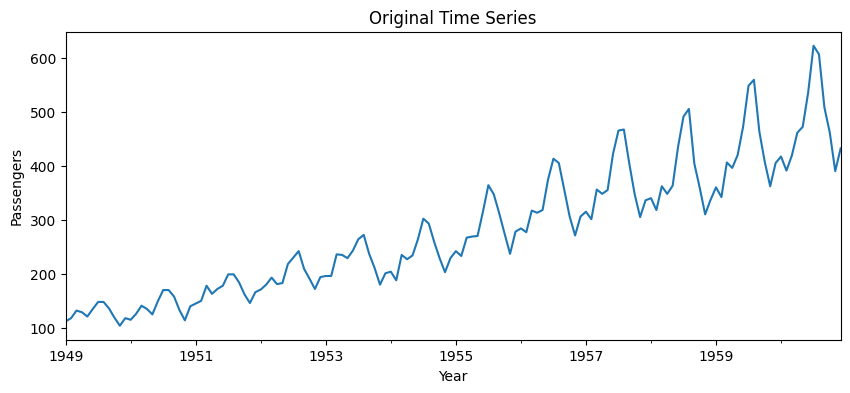

In [ ]:
plt.figure(figsize=(10, 4))
ts.plot(title='Original Time Series', ylabel="Passengers", xlabel="Year")
plt.show()

## Visual inspection

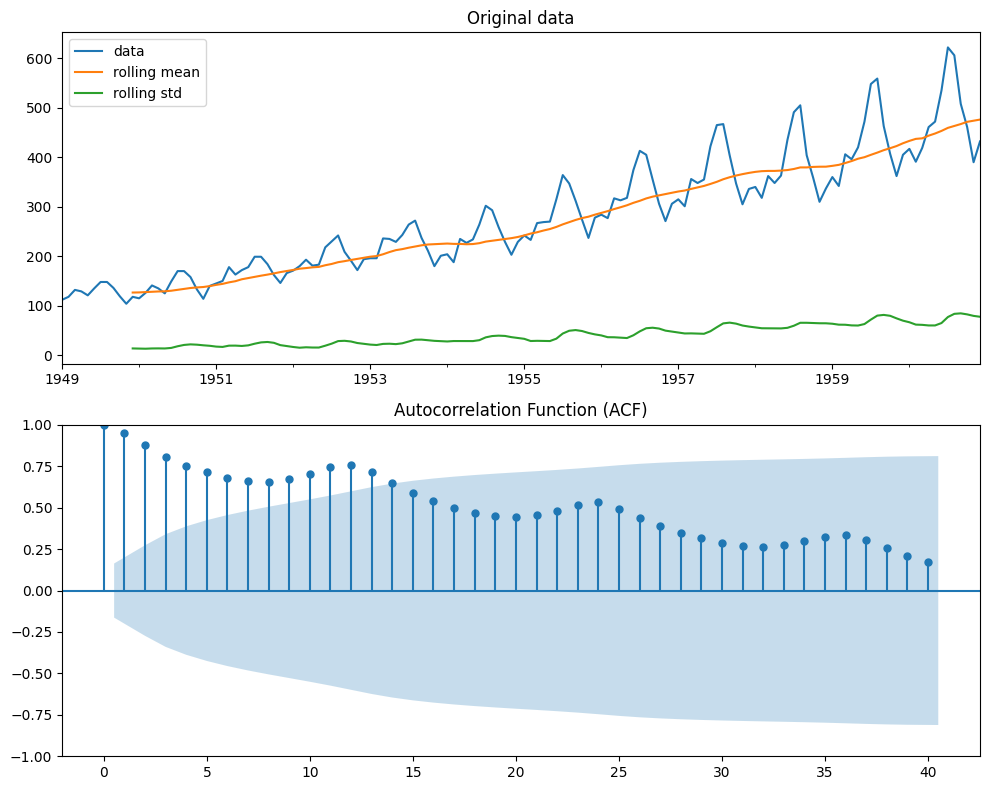

In [ ]:
plot_stationarity_visuals(ts, "Original data", include_pacf=False)

## Augmented Dickey-Fuller (ADF) test

The ADF test checks whether a time series has a unit root, which indicates non-stationarity.

- Null Hypothesis ($H_0$): The series has a unit root → **Non-stationary**.
- Alternative Hypothesis ($H_1$): The series is **stationary**.

With threshold of 5 %
- If **p-value < 0.05**, reject $H_0$ → The series is likely **stationary**.
- If **p-value ≥ 0.05**, fail to reject $H_1$ → The series is likely **non-stationary**.

The test uses a regression that includes lagged terms to account for autocorrelation.



In [ ]:
print("ADF Test on Original Series:")
adf_test(ts)

ADF Test on Original Series:
p-value: 0.991880243437641
Non-stationary


## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

The KPSS test checks whether a time series is stationary around a deterministic trend.

- Null Hypothesis ($H_0$): The series is **stationary**.
- Alternative Hypothesis ($H_1$): The series is **non-stationary**.

With threshold of 5 %
- If **p-value < 0.05**, reject $H_0$ → The series is likely **non-stationary**.
- If **p-value ≥ 0.05**, fail to reject $H_1$ → The series is likely **stationary**.

Using ADF and KPSS together gives a more robust stationarity check.

In [ ]:
print("KPSS Test on Original Series:")
kpss_test(ts)

KPSS Test on Original Series:
p-value: 0.01
Non-stationary


# Techniques to achieve Stationarity

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*cdD_5S-5LT1erd-4KrF75w.png)

Referece: https://prof-frenzel.medium.com/kb-time-series-data-part-3-6e32032f7b49

# Differencing (Differentiating in discrete time)

* Subtract the previous observation from the current
  * $Y_t' = Y_t-Y_{t-1}$
* Also posible in higher order
  * $Y_t'' = Y_t'-Y_{t-1}'$

* Removes trends in the dataset
* Can amplify noise, especialy with higher order differencing

p-value: 0.05421329028382478
Non-stationary
p-value: 0.1
Stationary


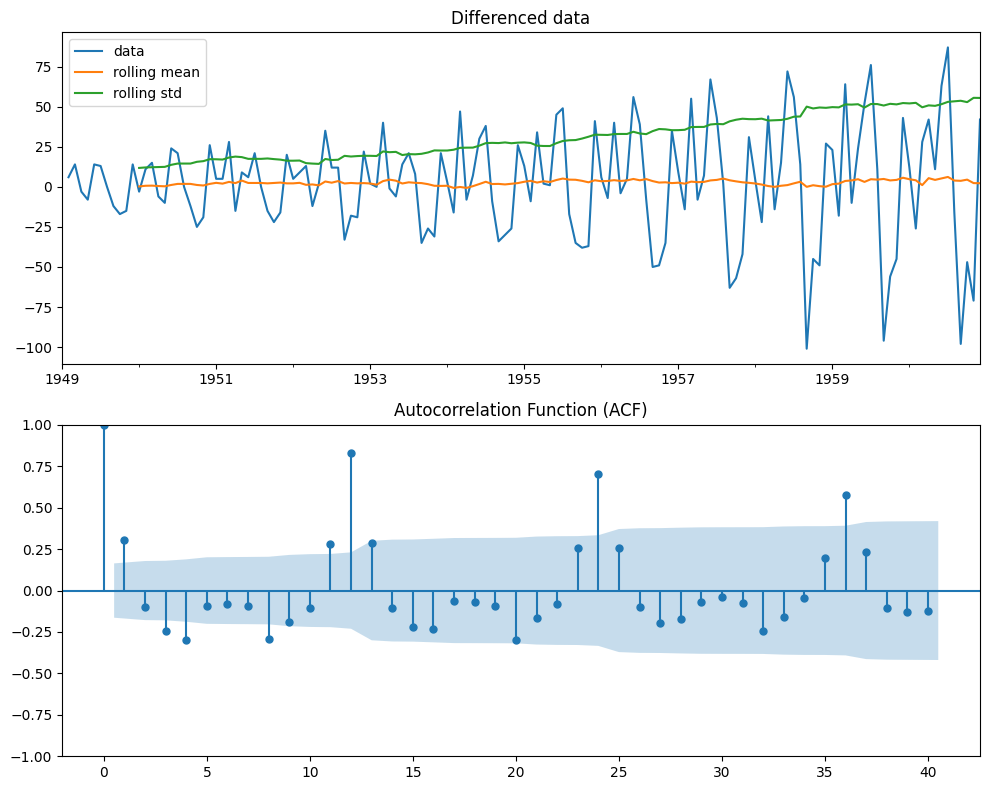

In [ ]:
# Differencing (1st and 2nd order)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create synthetic time series with trend
ts_differencing = ts

# First-order differencing
first_diff = ts_differencing.diff()

# Second-order differencing
second_diff = first_diff.diff()

# Second-order differencing seasonal
seasonal_diff = first_diff.diff(periods=12)

calculate_metrics(first_diff)
plot_stationarity_visuals(first_diff, "Differenced data", include_pacf=False)


## Second order differencing
Second order differencing introduces a lot more noise.

p-value: 2.7328918500142026e-29
Stationary
p-value: 0.1
Stationary


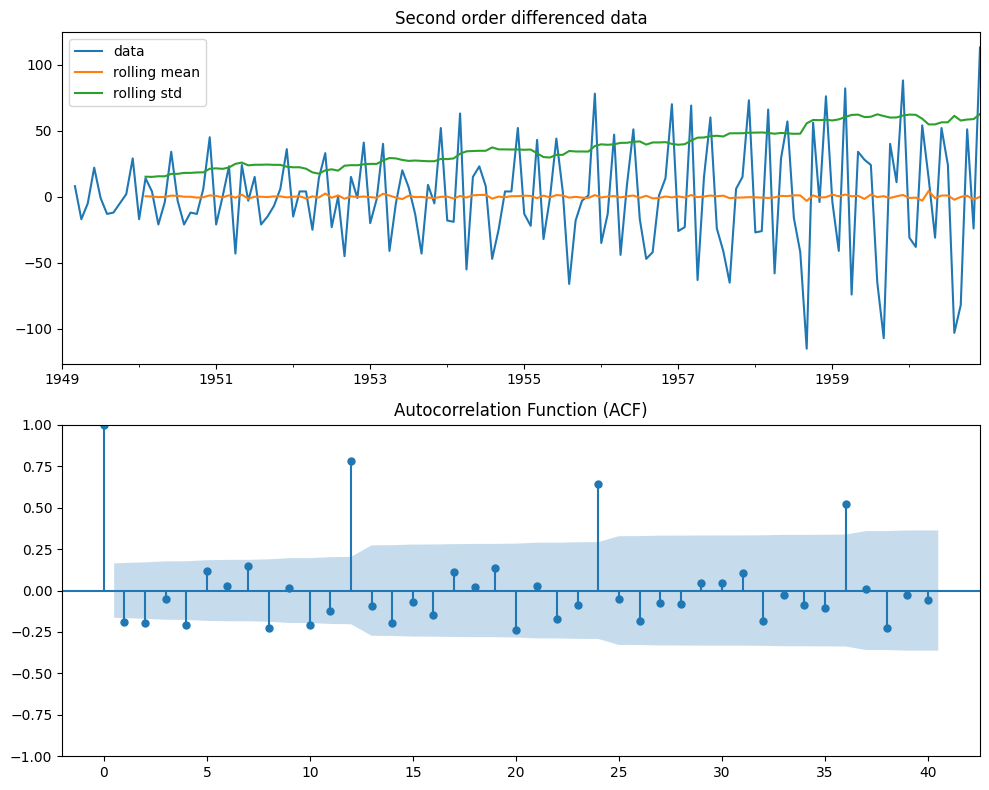

In [ ]:
calculate_metrics(second_diff)
plot_stationarity_visuals(second_diff, "Second order differenced data", include_pacf=False)

## Seasonal differentiating


p-value: 1.856511600123444e-28
Stationary
p-value: 0.1
Stationary


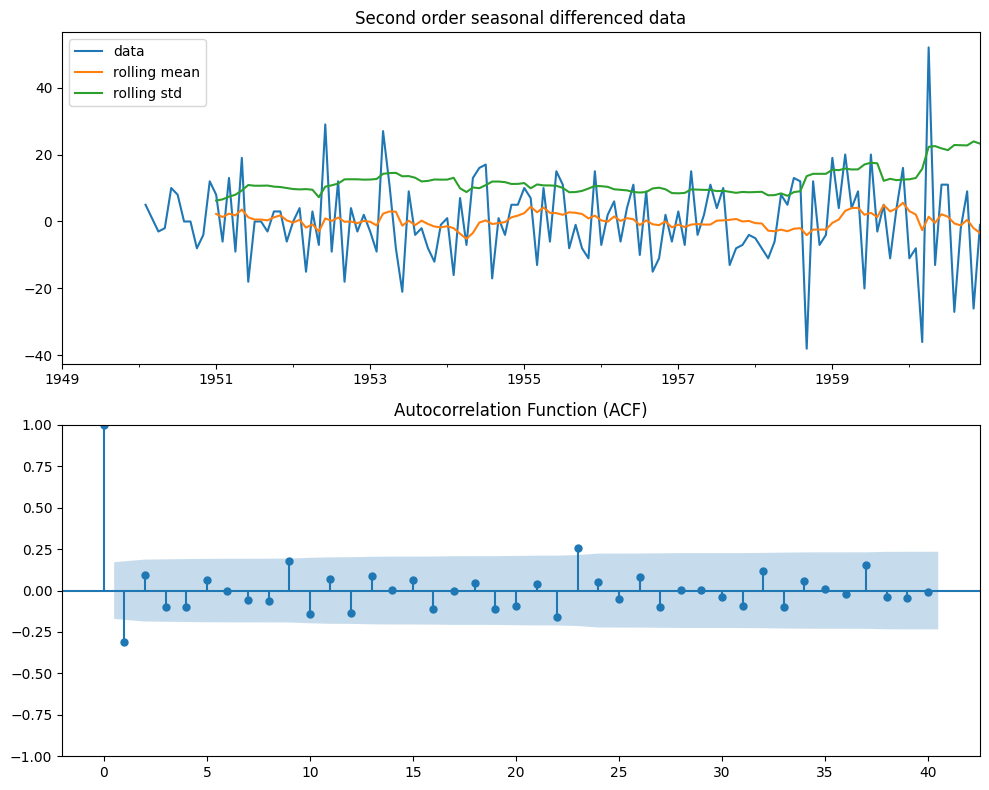

In [ ]:
calculate_metrics(seasonal_diff)
plot_stationarity_visuals(seasonal_diff, "Second order seasonal differenced data", include_pacf=False)


# Detrending by the use of linear regression and moving average

* Make a regression of the data, eg: linear regression or moving average

* Substract the regression value from the original value
  * $Y_{stationary} = Y_{original}-Y_{regresion}$


This:
* Removes trends in the dataset
* Easy to interperate
* But, you have to "find" a regression that fits the trend


ADF and KPSS Test on Linear Regression Detrended Series:
p-value: 0.24372483602015022
Non-stationary
p-value: 0.1
Stationary

ADF and KPSS Test on Moving Average Detrended Series:
p-value: 0.000609803815679232
Stationary
p-value: 0.1
Stationary


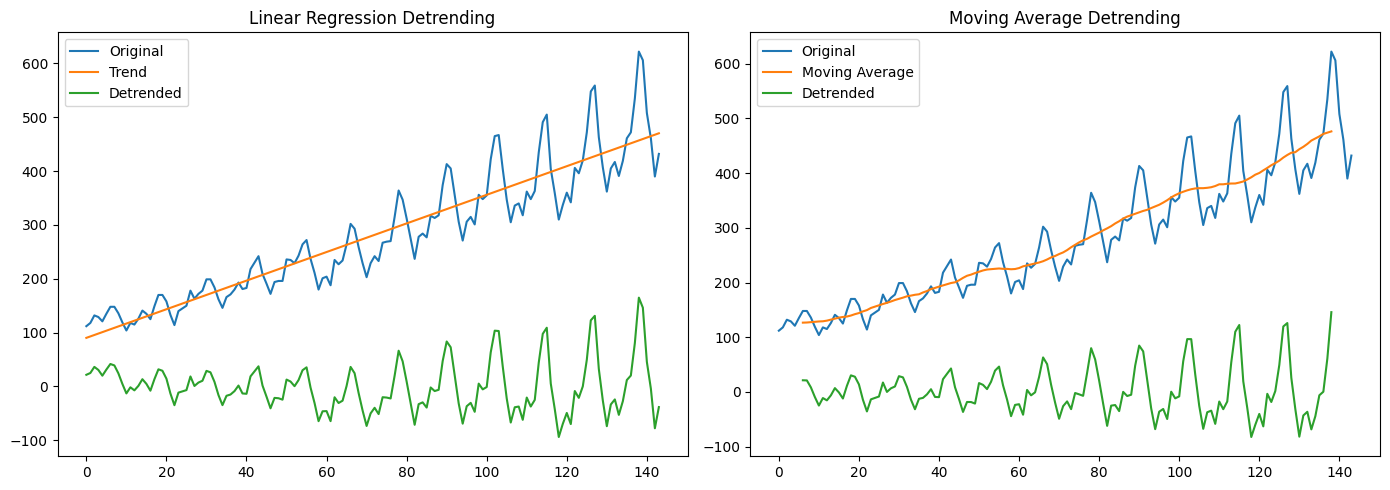

In [ ]:
detrended_lr, detrended_ma = detrending(ts)

# Transformations

## Log Transform
**What it’s good for**
- Stabilizes **variance** when variability grows with the level (heteroscedasticity).
- Converts **multiplicative** effects (e.g., growth, seasonal amplitude that scales with level) into **additive** ones.
- Makes exponential trends closer to linear.

**Characteristic equation**

$$
y'_t = \ln(y_t), \quad y_t > 0
$$

---

## Box–Cox Transform
**What it’s good for**
- Generalizes the log; chooses a power $\lambda$ that best **stabilizes variance** and **reduces skewness**.
- Useful when log is too strong/weak; lets the data pick the right power.

**Characteristic equation**

$$
y'_t =
\begin{cases}
\dfrac{y_t^{\lambda}-1}{\lambda}, & \lambda \neq 0 \\
\ln(y_t), & \lambda = 0
\end{cases}
\qquad (y_t > 0)
$$
- Log and Box–Cox mainly **stabilize variance**; by themselves they do not remove **trend/seasonality**.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.datasets import get_rdataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
warnings.filterwarnings("ignore")
from scipy.stats import boxcox

# Load sample dataset
data = get_rdataset("AirPassengers", "datasets").data
ts = pd.Series(data['value'].values, index=pd.date_range(start='1949-01', periods=len(data), freq='ME'))
# === Part 1 — All calculations needed =======================================
# Assumes: ts (pd.Series with DatetimeIndex), and you already imported:
# numpy as np, pandas as pd, matplotlib.pyplot as plt, adfuller, kpss, boxcox

# Helpers
def adf_kpss(series, name="series"):
    s = series.dropna()
    adf_p  = adfuller(s, autolag="AIC")[1]
    try:
        kpss_p = kpss(s, regression="c", nlags="auto")[1]
    except:
        kpss_p = kpss(s, regression="ct", nlags="auto")[1]
    print(f"{name:32s} | ADF p = {adf_p:7.5f} (low→stationary) | KPSS p = {kpss_p:7.5f} (high→stationary)")

def rolling_var(series, window=12):
    return series.rolling(window, min_periods=window//2).var()

def normalize(s):
    med = s.median()
    return s / med if med and np.isfinite(med) else s

# Transforms
ts_log = np.log(ts)                          # Log transform
ts_bc_vals, lam = boxcox(ts.values)          # Box–Cox (strictly positive data)
ts_bc = pd.Series(ts_bc_vals, index=ts.index)
ts_logdiff = ts_log.diff().dropna()          # Log-percentage change

# Rolling variances (12 months)
win = 12
rv_raw = rolling_var(ts, win)
rv_log = rolling_var(ts_log, win)
rv_bc  = rolling_var(ts_bc, win)
rv_ld  = rolling_var(ts_logdiff, win)


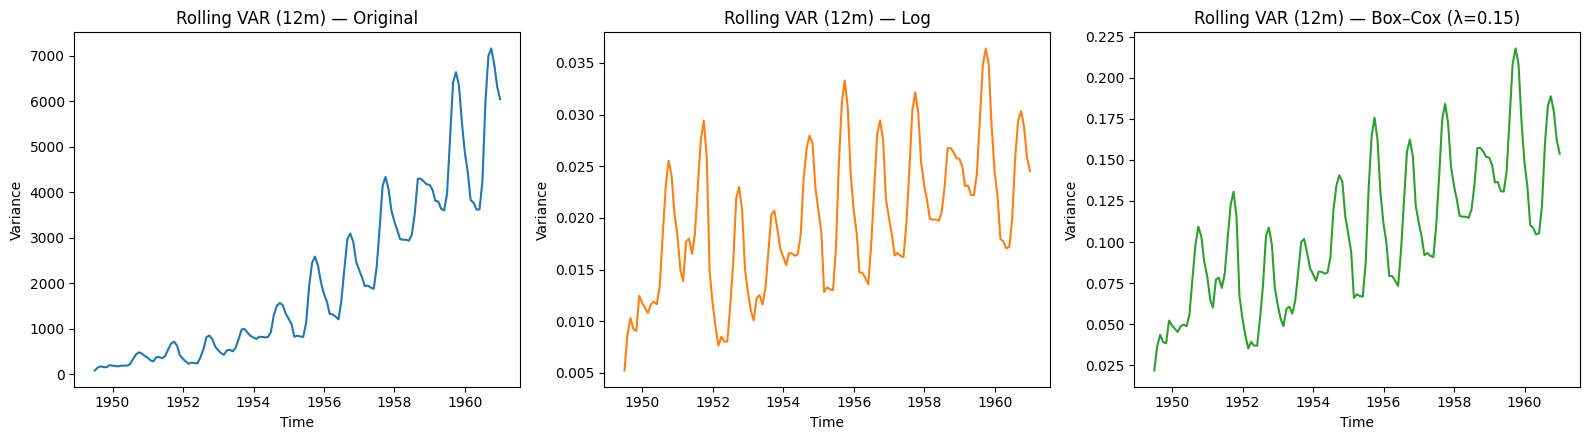

Stationarity checks (for transforms in this part):
Log (no differencing)            | ADF p = 0.42237 (low→stationary) | KPSS p = 0.01000 (high→stationary)
Box–Cox (λ=0.15) (no differencing) | ADF p = 0.61716 (low→stationary) | KPSS p = 0.01000 (high→stationary)


In [ ]:
# === Part 2 — Variance plots (original, log, box–cox) + ADF/KPSS (log & box–cox)

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharex=False)
axes[0].plot(rv_raw, color='C0');             axes[0].set_title('Rolling VAR (12m) — Original')
axes[1].plot(rv_log, color='C1');             axes[1].set_title('Rolling VAR (12m) — Log')
axes[2].plot(rv_bc,  color='C2');             axes[2].set_title(f'Rolling VAR (12m) — Box–Cox (λ={lam:.2f})')
for ax in axes:
    ax.set_xlabel('Time'); ax.set_ylabel('Variance')
plt.tight_layout(); plt.show()

print("Stationarity checks (for transforms in this part):")
adf_kpss(ts_log, "Log (no differencing)")
adf_kpss(ts_bc,  f"Box–Cox (λ={lam:.2f}) (no differencing)")



## Log-Difference (Percentage Change)
**What it’s good for**
- Removes **multiplicative trend** in one step; approximates **percentage growth**.
- Often yields a series with **more stable mean and variance** when the original grows exponentially.
- Interpretable: $100\times y'_t$ is approximately the **% change** from $t-1$ to $t$.

**Characteristic equation**

$$
y'_t = \ln(y_t) - \ln(y_{t-1})
= \ln\!\left(\frac{y_t}{y_{t-1}}\right)
\approx \frac{y_t - y_{t-1}}{y_{t-1}}
$$
- Log-difference targets **multiplicative trend**; if seasonality remains, apply **seasonal differencing** afterward (e.g., $\Delta_{12}\ln y_t$).

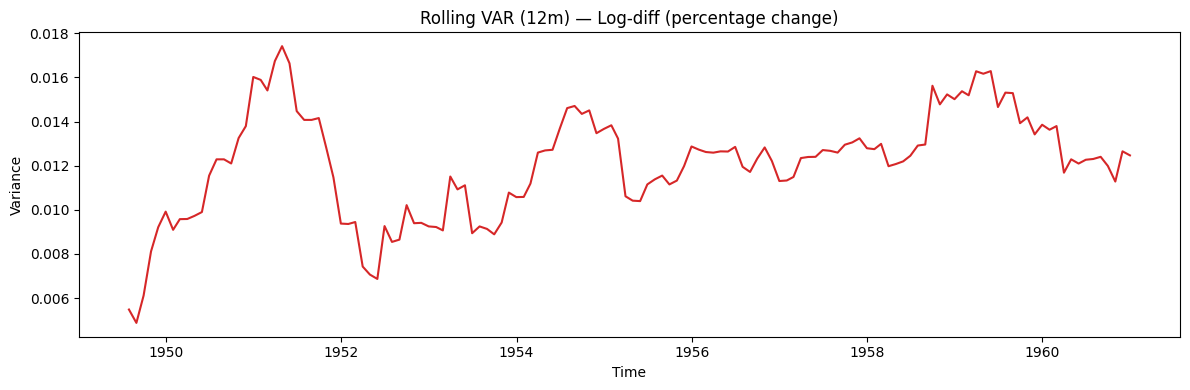

Stationarity check (log-diff / percentage change):
Log-diff (percentage change)     | ADF p = 0.07112 (low→stationary) | KPSS p = 0.10000 (high→stationary)


In [ ]:
# === Part 3 — Variance plot (log-percentage change) + ADF/KPSS

plt.figure(figsize=(12,4))
plt.plot(rv_ld, color='C3')
plt.title('Rolling VAR (12m) — Log-diff (percentage change)')
plt.xlabel('Time'); plt.ylabel('Variance')
plt.tight_layout(); plt.show()

print("Stationarity check (log-diff / percentage change):")
adf_kpss(ts_logdiff, "Log-diff (percentage change)")


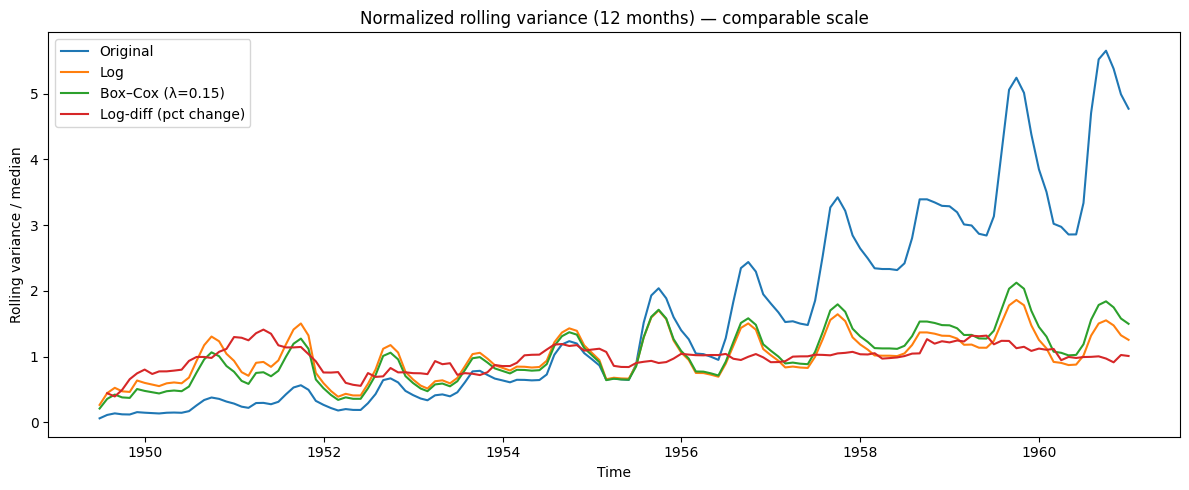

In [ ]:
# === Part 4 — Normalized rolling variance comparison (all on one plot)

rv_raw_n = normalize(rv_raw)
rv_log_n = normalize(rv_log)
rv_bc_n  = normalize(rv_bc)
rv_ld_n  = normalize(rv_ld)

plt.figure(figsize=(12,5))
plt.plot(rv_raw_n, label='Original')
plt.plot(rv_log_n, label='Log')
plt.plot(rv_bc_n,  label=f'Box–Cox (λ={lam:.2f})')
plt.plot(rv_ld_n,  label='Log-diff (pct change)')
plt.title('Normalized rolling variance (12 months) — comparable scale')
plt.ylabel('Rolling variance / median'); plt.xlabel('Time')
plt.legend()
plt.tight_layout(); plt.show()


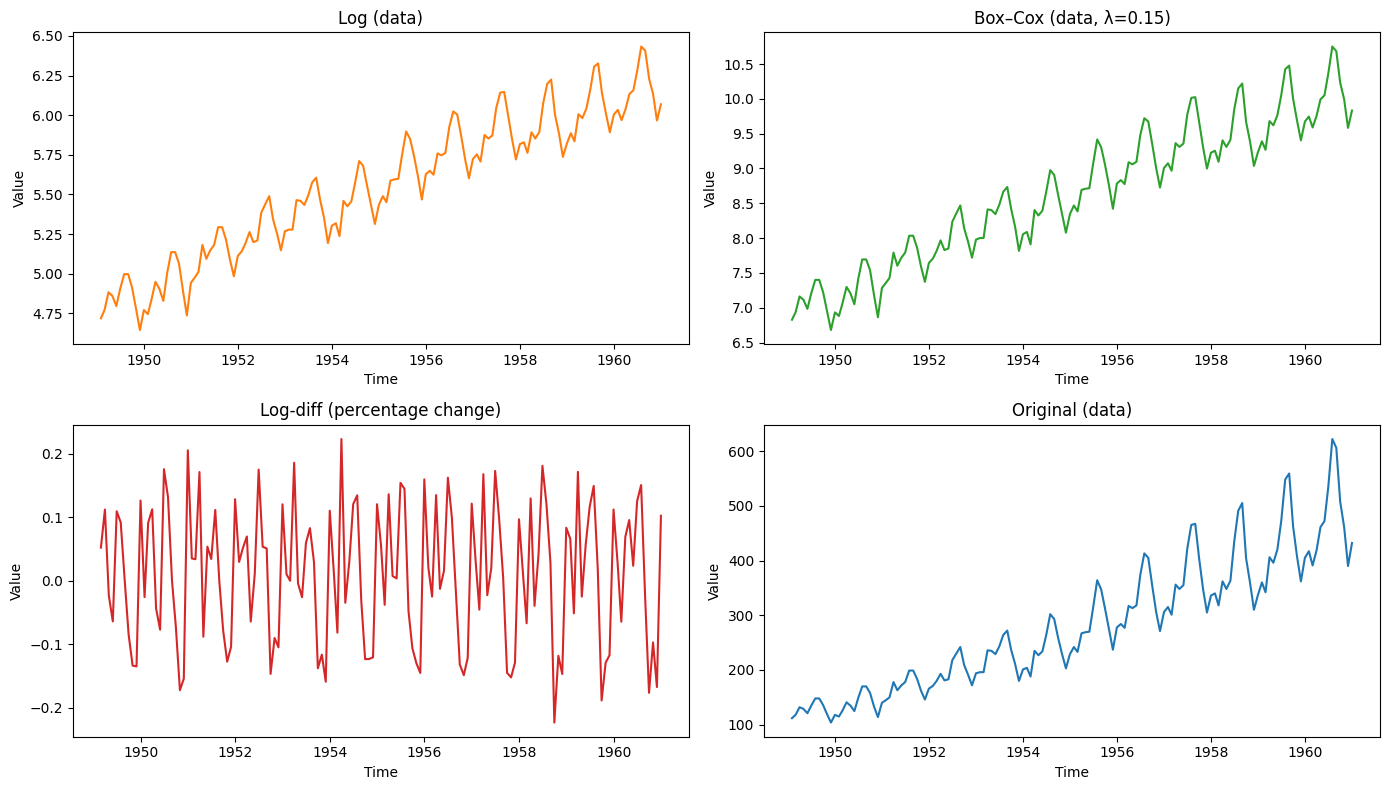

In [ ]:
# === Part 5 — Plot the DATA (not variances): original + transformed

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=False)
axes = axes.ravel()
axes[0].plot(ts_log, color='C1');         axes[0].set_title("Log (data)")
axes[1].plot(ts_bc,  color='C2');         axes[1].set_title(f"Box–Cox (data, λ={lam:.2f})")
axes[2].plot(ts_logdiff, color='C3');     axes[2].set_title("Log-diff (percentage change)")
axes[3].plot(ts, color='C0');             axes[3].set_title("Original (data)")
for ax in axes:
    ax.set_xlabel("Time"); ax.set_ylabel("Value")
plt.tight_layout(); plt.show()


# Best practices
* What is your goal?
  * Forecasting
  * Detecting anomalies
  * Identifying underlying patterns
* Identify and handle outliers/anomalies (removal, capping, imputation)
* The choice of the method and its parameters  can significantly influence the results
* Test for stationarity after application of selected method

# Common pitfalls
* Differentiation can lead to loss of information
* Seasonal decomposition assumes that the components are separable and do not interact
* Trends can be evolving with time


# Additional examples for each method, on synthetic data

* Differencing
* Detrending
* Transform
* Despiking
* Seasonal time series
  * Differencing
  * Decomposing

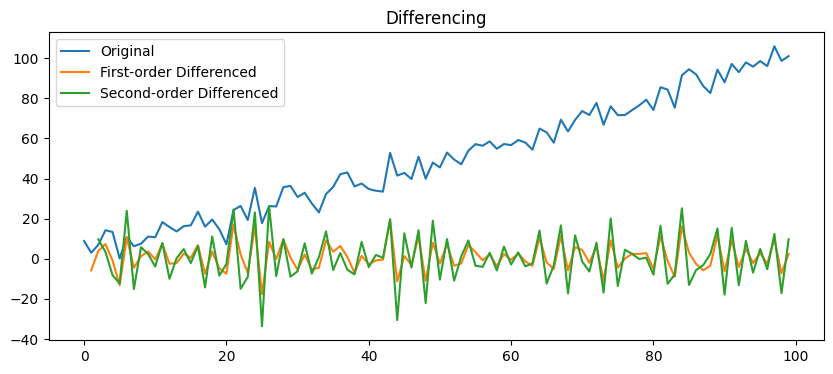

In [ ]:
# Differencing (1st and 2nd order)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create synthetic time series with trend
np.random.seed(0)
t = np.arange(100)
series = t + np.random.normal(scale=5, size=100)

# First-order differencing
first_diff = np.diff(series)

# Second-order differencing
second_diff = np.diff(first_diff)

plt.figure(figsize=(10, 4))
plt.plot(series, label='Original')
plt.plot(np.arange(1, 100), first_diff, label='First-order Differenced')
plt.plot(np.arange(2, 100), second_diff, label='Second-order Differenced')
plt.legend()
plt.title("Differencing")
plt.show()

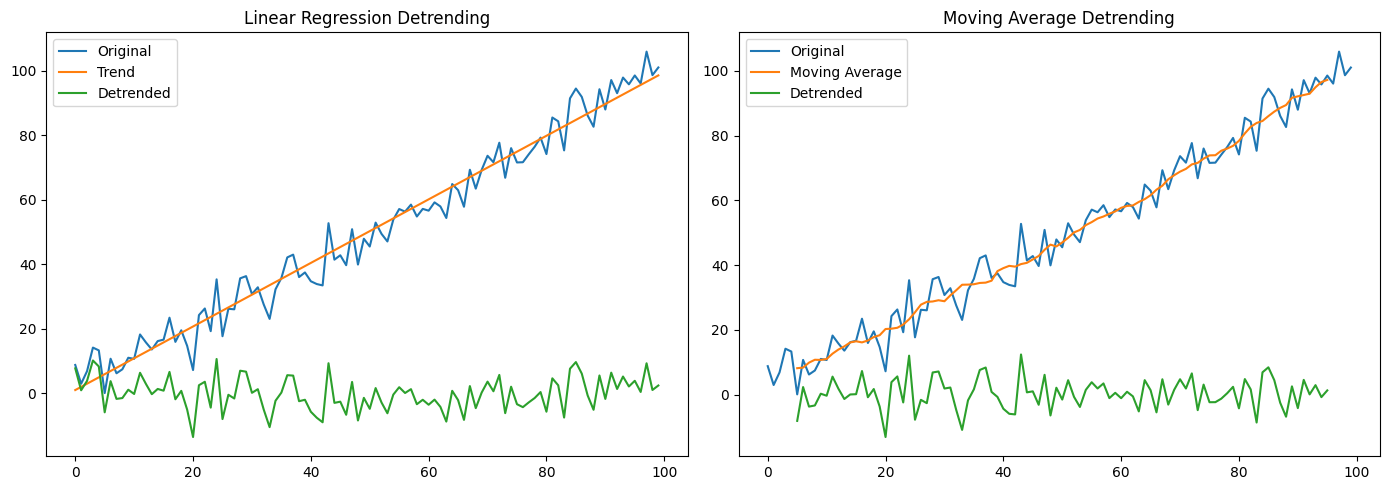

In [ ]:
from sklearn.linear_model import LinearRegression

# Create synthetic time series with trend
np.random.seed(0)
t = np.arange(100)
series = t + np.random.normal(scale=5, size=100)

# Linear Regression Detrending
X = t.reshape(-1, 1)
y = series
model = LinearRegression().fit(X, y)
trend = model.predict(X)
detrended_lr = y - trend

# Moving Average Detrending
rolling_mean = pd.Series(series).rolling(window=10, center=True).mean()
detrended_ma = series - rolling_mean

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Linear Regression Detrending
axes[0].plot(y, label='Original')
axes[0].plot(trend, label='Trend')
axes[0].plot(detrended_lr, label='Detrended')
axes[0].set_title("Linear Regression Detrending")
axes[0].legend()

# Plot Moving Average Detrending
axes[1].plot(series, label='Original')
axes[1].plot(rolling_mean, label='Moving Average')
axes[1].plot(detrended_ma, label='Detrended')
axes[1].set_title("Moving Average Detrending")
axes[1].legend()

plt.tight_layout()

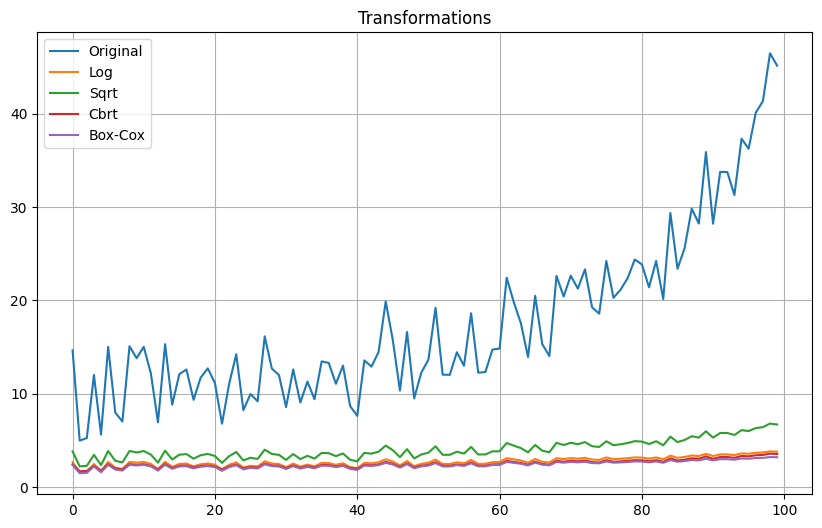

In [ ]:
#4. Transformations (Log, √, ³√, Box-Cox)
from scipy.stats import boxcox

# Positive synthetic data
positive_series = 8+np.exp(np.linspace(0, 3.5, 100)) + np.random.normal(scale=3, size=100)

log_trans = np.log(positive_series)
sqrt_trans = np.sqrt(positive_series)
cbrt_trans = np.cbrt(positive_series)
boxcox_trans, _ = boxcox(positive_series)

plt.figure(figsize=(10, 6))
plt.plot(positive_series, label='Original')
plt.plot(log_trans, label='Log')
plt.plot(sqrt_trans, label='Sqrt')
plt.plot(cbrt_trans, label='Cbrt')
plt.plot(boxcox_trans, label='Box-Cox')
plt.legend()
plt.title("Transformations")
plt.grid(True)
plt.show()

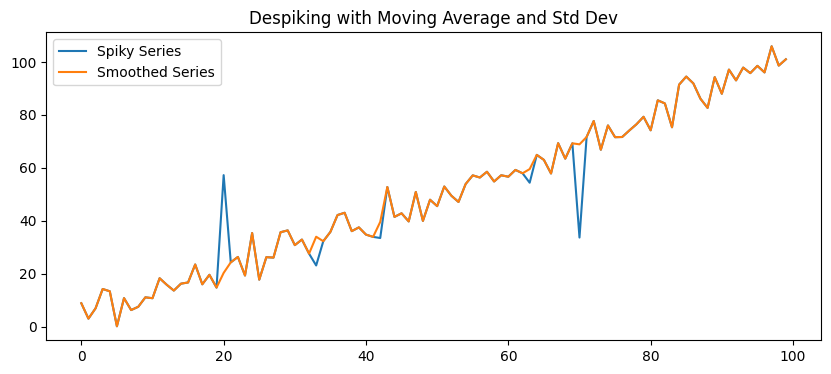

In [ ]:
#9. Despiking (Outlier Smoothing)
# Introduce spikes
spiky_series = series.copy()
spiky_series[20] += 50
spiky_series[70] -= 40

# Detect and smooth outliers
rolling_std = pd.Series(spiky_series).rolling(window=5).std()
threshold = 2 * rolling_std
smoothed = spiky_series.copy()
for i in range(len(spiky_series)):
    if i >= 5 and abs(spiky_series[i] - rolling_mean[i]) > threshold[i]:
        smoothed[i] = rolling_mean[i]

plt.figure(figsize=(10, 4))
plt.plot(spiky_series, label='Spiky Series')
plt.plot(smoothed, label='Smoothed Series')
plt.legend()
plt.title("Despiking with Moving Average and Std Dev")
plt.show()


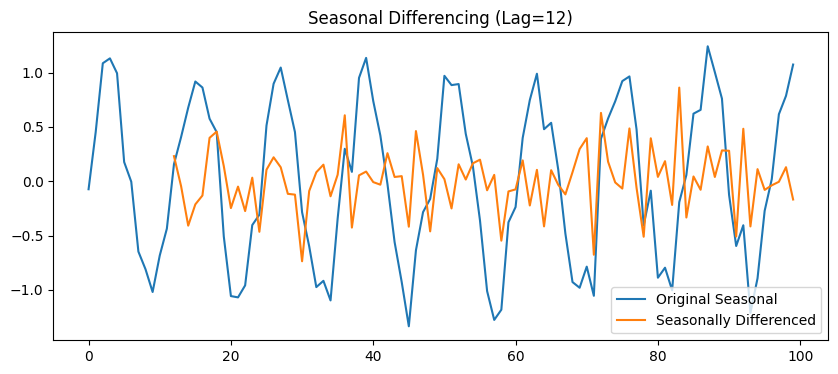

In [ ]:
#2. Seasonal Differencing
# Simulate seasonal data
seasonal_series = np.sin(2 * np.pi * t / 12) + np.random.normal(scale=0.2, size=100)

# Seasonal differencing (lag=12)
seasonal_diff = seasonal_series[12:] - seasonal_series[:-12]

plt.figure(figsize=(10, 4))
plt.plot(seasonal_series, label='Original Seasonal')
plt.plot(np.arange(12, 100), seasonal_diff, label='Seasonally Differenced')
plt.legend()
plt.title("Seasonal Differencing (Lag=12)")
plt.show()


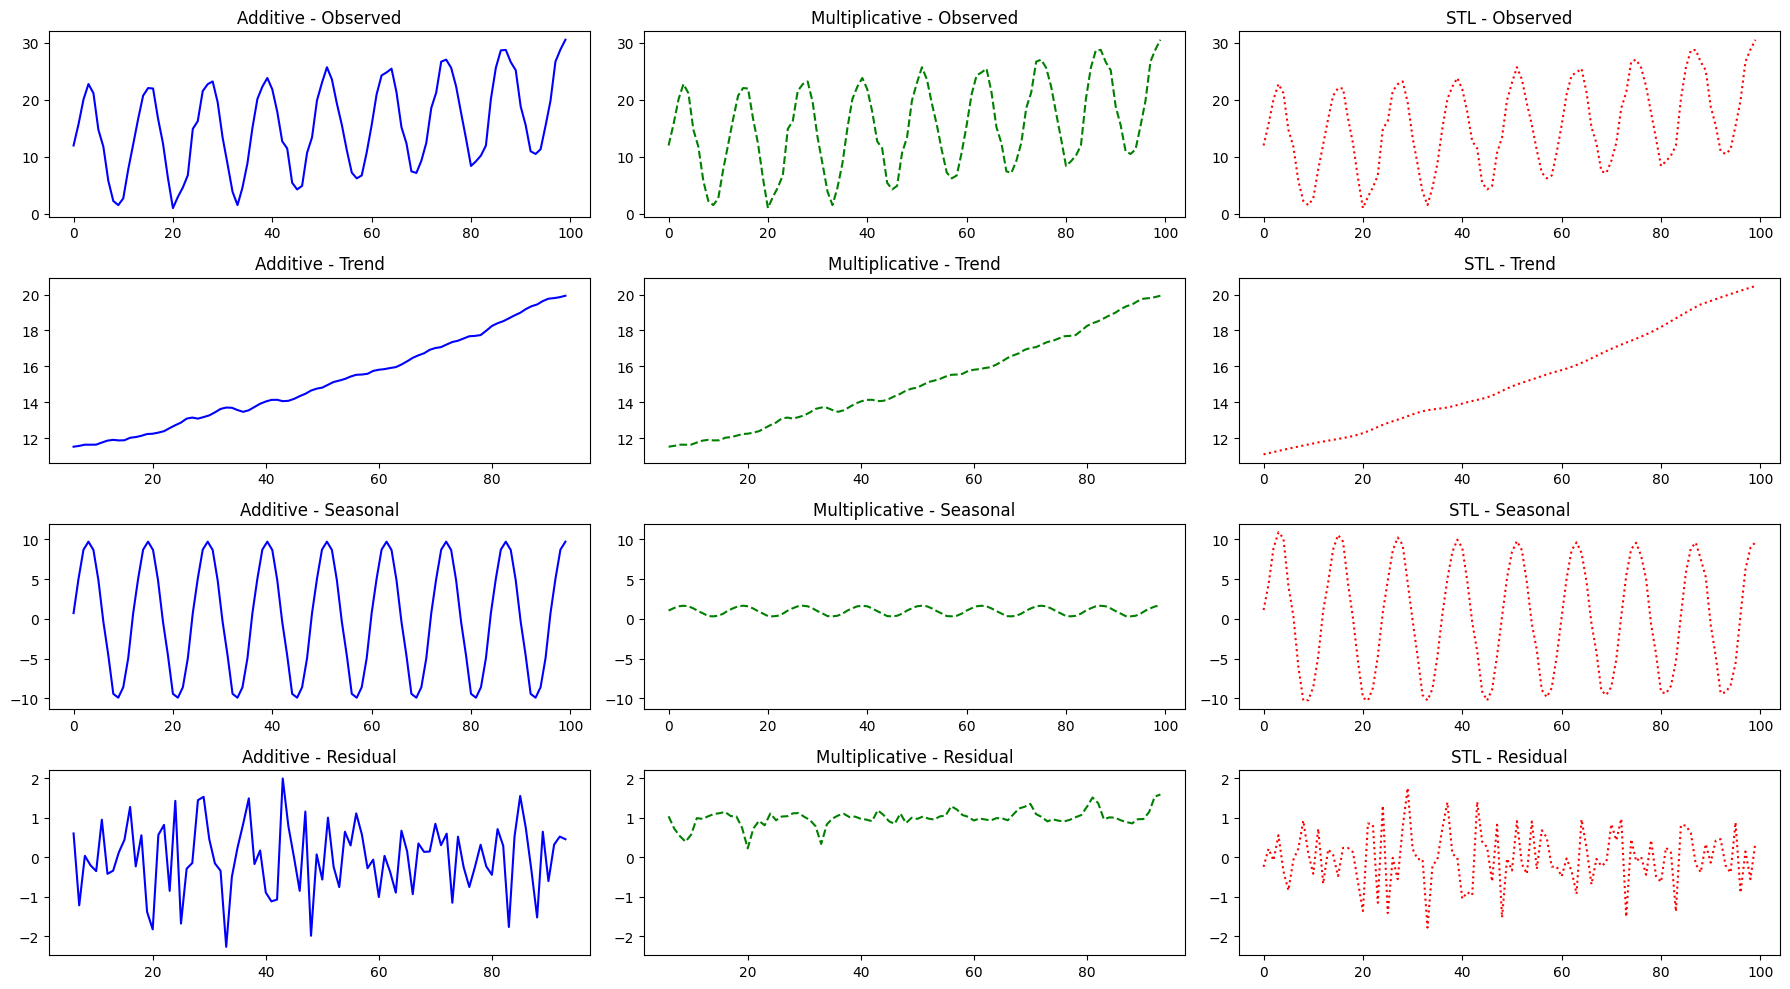

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

# Simulate seasonal + trend data
np.random.seed(0)
t = np.arange(100)
seasonal_series = 10 * np.sin(2 * np.pi * t / 12) + np.random.normal(scale=1, size=100)
ts = pd.Series(seasonal_series + t * 0.1)

# Shift series to make all values positive
ts_shifted = ts + abs(ts.min()) + 1

# Apply all decomposition methods to the shifted time series
add_decomp = seasonal_decompose(ts_shifted, model='additive', period=12)
mult_decomp = seasonal_decompose(ts_shifted, model='multiplicative', period=12)
stl = STL(ts_shifted, period=12)
stl_res = stl.fit()

# Create 4x3 subplot grid
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

# Define styles for each method
styles = {
    'Additive': {'color': 'blue', 'linestyle': '-'},
    'Multiplicative': {'color': 'green', 'linestyle': '--'},
    'STL': {'color': 'red', 'linestyle': ':'}
}

# Collect y-axis limits for each row
y_limits = {'Observed': [], 'Trend': [], 'Seasonal': [], 'Residual': []}

# Additive decomposition plots
obs = add_decomp.observed.plot(ax=axes[0, 0], title='Additive - Observed', **styles['Additive'])
y_limits['Observed'].append(obs.get_ylim())
trd = add_decomp.trend.plot(ax=axes[1, 0], title='Additive - Trend', **styles['Additive'])
y_limits['Trend'].append(trd.get_ylim())
sea = add_decomp.seasonal.plot(ax=axes[2, 0], title='Additive - Seasonal', **styles['Additive'])
y_limits['Seasonal'].append(sea.get_ylim())
res = add_decomp.resid.plot(ax=axes[3, 0], title='Additive - Residual', **styles['Additive'])
y_limits['Residual'].append(res.get_ylim())

# Multiplicative decomposition plots
obs = mult_decomp.observed.plot(ax=axes[0, 1], title='Multiplicative - Observed', **styles['Multiplicative'])
y_limits['Observed'].append(obs.get_ylim())
trd = mult_decomp.trend.plot(ax=axes[1, 1], title='Multiplicative - Trend', **styles['Multiplicative'])
y_limits['Trend'].append(trd.get_ylim())
sea = mult_decomp.seasonal.plot(ax=axes[2, 1], title='Multiplicative - Seasonal', **styles['Multiplicative'])
y_limits['Seasonal'].append(sea.get_ylim())
res = mult_decomp.resid.plot(ax=axes[3, 1], title='Multiplicative - Residual', **styles['Multiplicative'])
y_limits['Residual'].append(res.get_ylim())

# STL decomposition plots
obs = stl_res.observed.plot(ax=axes[0, 2], title='STL - Observed', **styles['STL'])
y_limits['Observed'].append(obs.get_ylim())
trd = stl_res.trend.plot(ax=axes[1, 2], title='STL - Trend', **styles['STL'])
y_limits['Trend'].append(trd.get_ylim())
sea = stl_res.seasonal.plot(ax=axes[2, 2], title='STL - Seasonal', **styles['STL'])
y_limits['Seasonal'].append(sea.get_ylim())
res = stl_res.resid.plot(ax=axes[3, 2], title='STL - Residual', **styles['STL'])
y_limits['Residual'].append(res.get_ylim())

# Set consistent y-axis limits for each row
for i, key in enumerate(['Observed', 'Trend', 'Seasonal', 'Residual']):
    min_y = min(limit[0] for limit in y_limits[key])
    max_y = max(limit[1] for limit in y_limits[key])
    for j in range(3):
        axes[i, j].set_ylim(min_y, max_y)

plt.tight_layout()
